## Analysis : Joint presence of Macrophage 2 : CXL10 and T-cells : IFIT1

This notebook contains all code used to generate Supplementary Figure X and X+1. It uses the _stereoscope_ cell type mappings to compute a metric associated with high presence of both cell types, what we refer to as a _joint score_.

We stratify the spots from each sample by cluster identity and show how the joint scores are distributed within these subsets by using a variant of the violin plot similar to [bean plots](https://cran.r-project.org/web/packages/beanplot/vignettes/beanplot.pdf). Our plots differ from the standard violin plot also showing each individual data point as a black horizontal line. We also indicate the median by a red cricle with a black edge. For this we provide our own function `bean_plot` that utilize the already exisiting _violinplot_ function in the plotting suite. 

## Load packages

In [73]:
from collections import Counter
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import os
import os.path as osp
from spw_enr import get_enr

## Define Functions and variables

In [70]:
# Bean plots are not available in
# matplotlib, this is a
# custom implementation utilzing
# the violinplot function

def bean_plot(ax : plt.Axes,
              vals : list,
              cmap,
              edgecolor : str = "black",
              max_width = 0.15,
              )->plt.Axes:

    xs = np.arange(len(vals))
    vps = ax.violinplot(vals,
                        showextrema=False,
                        positions = xs,
                        )

    ax.set_xticks(xs)

    for k,patch in enumerate(vps["bodies"]):
        patch.set_facecolor(clu_cmap(k))
        patch.set_edgecolor(edgecolor)
        patch.set_alpha(1.0)


    for center,dist in zip(xs,vals):
        points,counts = np.unique(dist,return_counts = True)
        delta = max_width / 2

        _xp = (center - delta,
               center + delta)

        _xp = np.array(_xp)

        mu = np.median(dist)

        ax.plot((center - delta * 2,
                 center + delta * 2),
                (mu,mu),
                linewidth = 2,
                color  = "red",
                )

        ax.scatter(center,
                   mu,
                   facecolor = "red",
                   edgecolor = "black",
                   zorder = np.inf,
        )

        for p in points:

            _yp = (p,p)

            ax.plot(_xp,
                    _yp,
                    color = "black",
                    linewidth=1.5,
                    alpha =0.3,
                    )

    return vps

In [89]:
# current working directory is 
# assumed to be "her2st/scripts"

# directory for proportion values
PROP_DIR = "../res/ST-deconv/props/subset"
# directory for cluster labels
CLU_DIR = "../res/ST-cluster/lbl/"
# directory for counts
CNT_DIR = "../data/ST-cnts/"

# GO-SET Path
GO_PTH = "../data/go-sets/go-0060337.csv"

# directory to save figures to
RES_DIR = "/tmp/ifn"
if not osp.exists(RES_DIR):
    import os
    os.mkdir(RES_DIR)

# name of cell types to look at 
# joint presence of
ct_1 = "T-cells : IFIT1"
ct_2 = "Macrophage 2 :CXCL10"
label_col = "label"

# perform z-score transformation
# of joint prop.value
z_score_transformation = True
# save figures
save = True

## Load and process data

In [84]:
go_set = pd.read_csv(GO_PTH,
                    sep = ",",
                     header = 0,
                     index_col = 0,
                    )

go_set = go_set.name.values.tolist()


In [88]:
cnts

{}

In [91]:
# get paths to proportion values
props = os.listdir(PROP_DIR)
# get path to  annotations (clusters)
annot = os.listdir(CLU_DIR)
# get paths to counts
cnts = os.listdir(CNT_DIR)

# sort paths
annot.sort()
props.sort()

# filter to only get tsv files (or compressed tsv)
format_filter = lambda x: x.endswith(".tsv") or x.endswith(".tsv.gz")
# filters to get sample identifiers 
annot_filter = lambda x: x.split("-")[0]
props_filter = lambda x : x.split("-")[0]
cnt_filter = lambda x : x.split(".")[0]

# pair annotation path with sample id
annot = list(filter(format_filter,annot))
annot_tag = list(map(annot_filter,annot))
annot = {k:d for k,d in zip(annot_tag,annot)}

# pair proportion path with sample id
props = list(filter(format_filter,props))
props = {props_filter(x):x for x in props if props_filter(x) in annot_tag}

# get count paths
cnts = list(filter(format_filter,cnts))
cnts = {cnt_filter(x):x for x in cnts if cnt_filter(x) in annot_tag}


# only keep labels for which proportion values exists
annot = {k:v for k,v in annot.items() if k in props.keys()}
# read proportion values, needed later on as well
props = {k:pd.read_csv(osp.join(PROP_DIR,p),
                       sep = "\t",
                       header = 0,
                       index_col = 0) for k,p in props.items() }
# read counts, needed later on as well
cnts = {k:pd.read_csv(osp.join(CNT_DIR,p),
                      sep = "\t",
                      header = 0,
                      index_col = 0) for k,p in cnts.items() }


# dictionary for coordinates
crds = dict()

# to convert float to rounded string, for index
ceilintstr = lambda x : str(int(np.round(x,0)))

# iterate over samples
for k,p in annot.items():
    # read annotations
    tmp = pd.read_csv(osp.join(CLU_DIR,p),
                      sep = "\t",
                      header = 0,
                      index_col = 0)
    # only data keep from proper sample
    tmp = tmp.iloc[tmp.ids.values == k,:]
    # remove any NA elements
    drop = tmp.isna().values.any(axis=1)
    tmp = tmp.iloc[~drop,:]
    # assemple new index, matching proportion values
    new_idx = pd.Index([ceilintstr(x) + \
                        "x" +\
                        ceilintstr(y) for\
                        x,y in zip(tmp.x.values,tmp.y.values)])
    # set new index
    tmp.index = new_idx
    # match annotations and proportion values
    inter = props[k].index.intersection(tmp.index).intersection(cnts[k].index)
    props[k] = props[k].loc[inter,:]
    annot[k] = tmp.loc[inter,:]
    cnts[k] = cnts[k].loc[inter,:]
    # get coordinates
    crds[k] = annot[k][["pixel_x","pixel_y"]].values



## Compute joint scores

In [92]:
# to keep results, used for bean plots
res = dict()
# to store joint prop. values, used for spatial plots
prods = dict()
# to store cluster positions, boolean
clu_pos = dict()
# to store enrichment scores
enr_scores = dict()

# iterate over all samples
for sample in annot.keys():
    
    # add new entry to res. dict
    res[sample] = dict()
    # compute joint score
    prod = props[sample][ct_1].values *  props[sample][ct_2].values
    
    # z-score transformation
    
    if z_score_transformation:
        mu = prod.mean()
        sigma = prod.std()
        prod = ( prod - mu ) / sigma
    
    # get unique labels in sample
    uni_labs = np.unique(annot[sample][label_col].values)
    # store joint score for sample
    prods[sample] = prod
    # store enrichment score
    
    enr_scores[sample] = get_enr(cnts[sample],
                                go_set,
                                )
    # initiate sample cluster position dict
    clu_pos[sample] = dict()
    
    # for each cluster add joint product to results
    # also add boolan vector for coordinates
    for lab in uni_labs:
        pos = annot[sample][label_col].values == lab
        clu_pos[sample][lab] = pos
        res[sample][lab] = prod[pos]

## Visualize Results

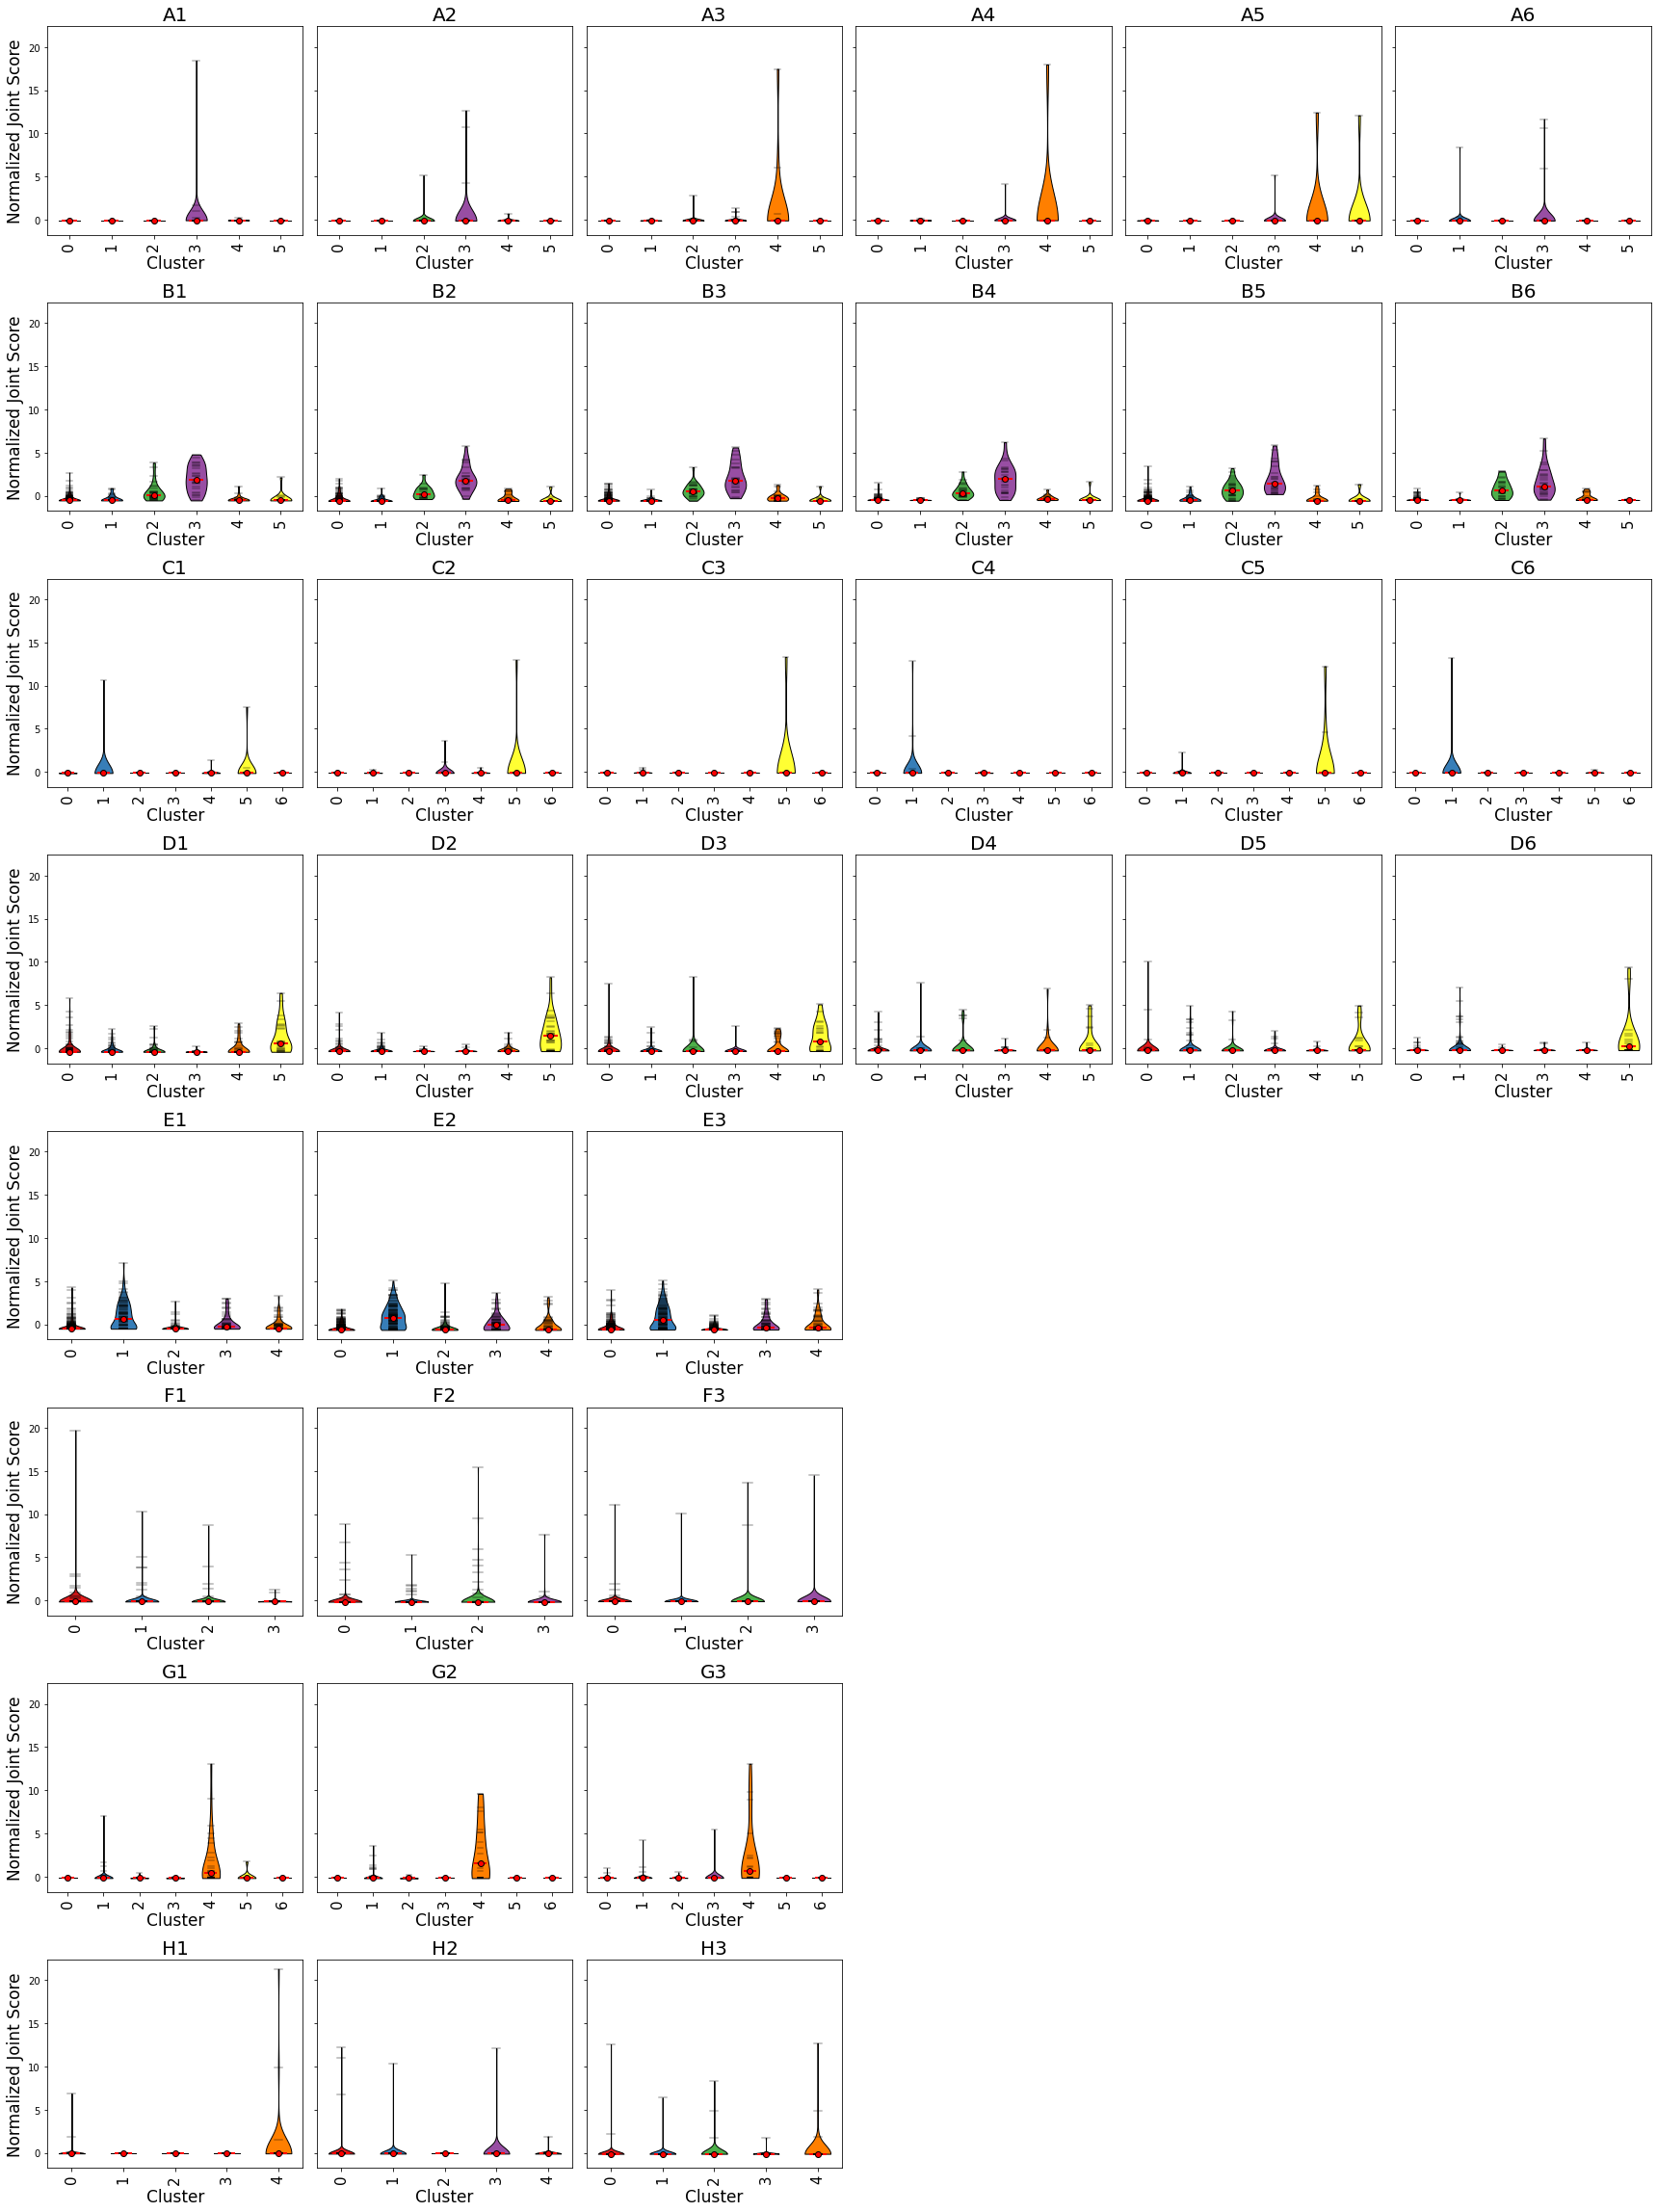

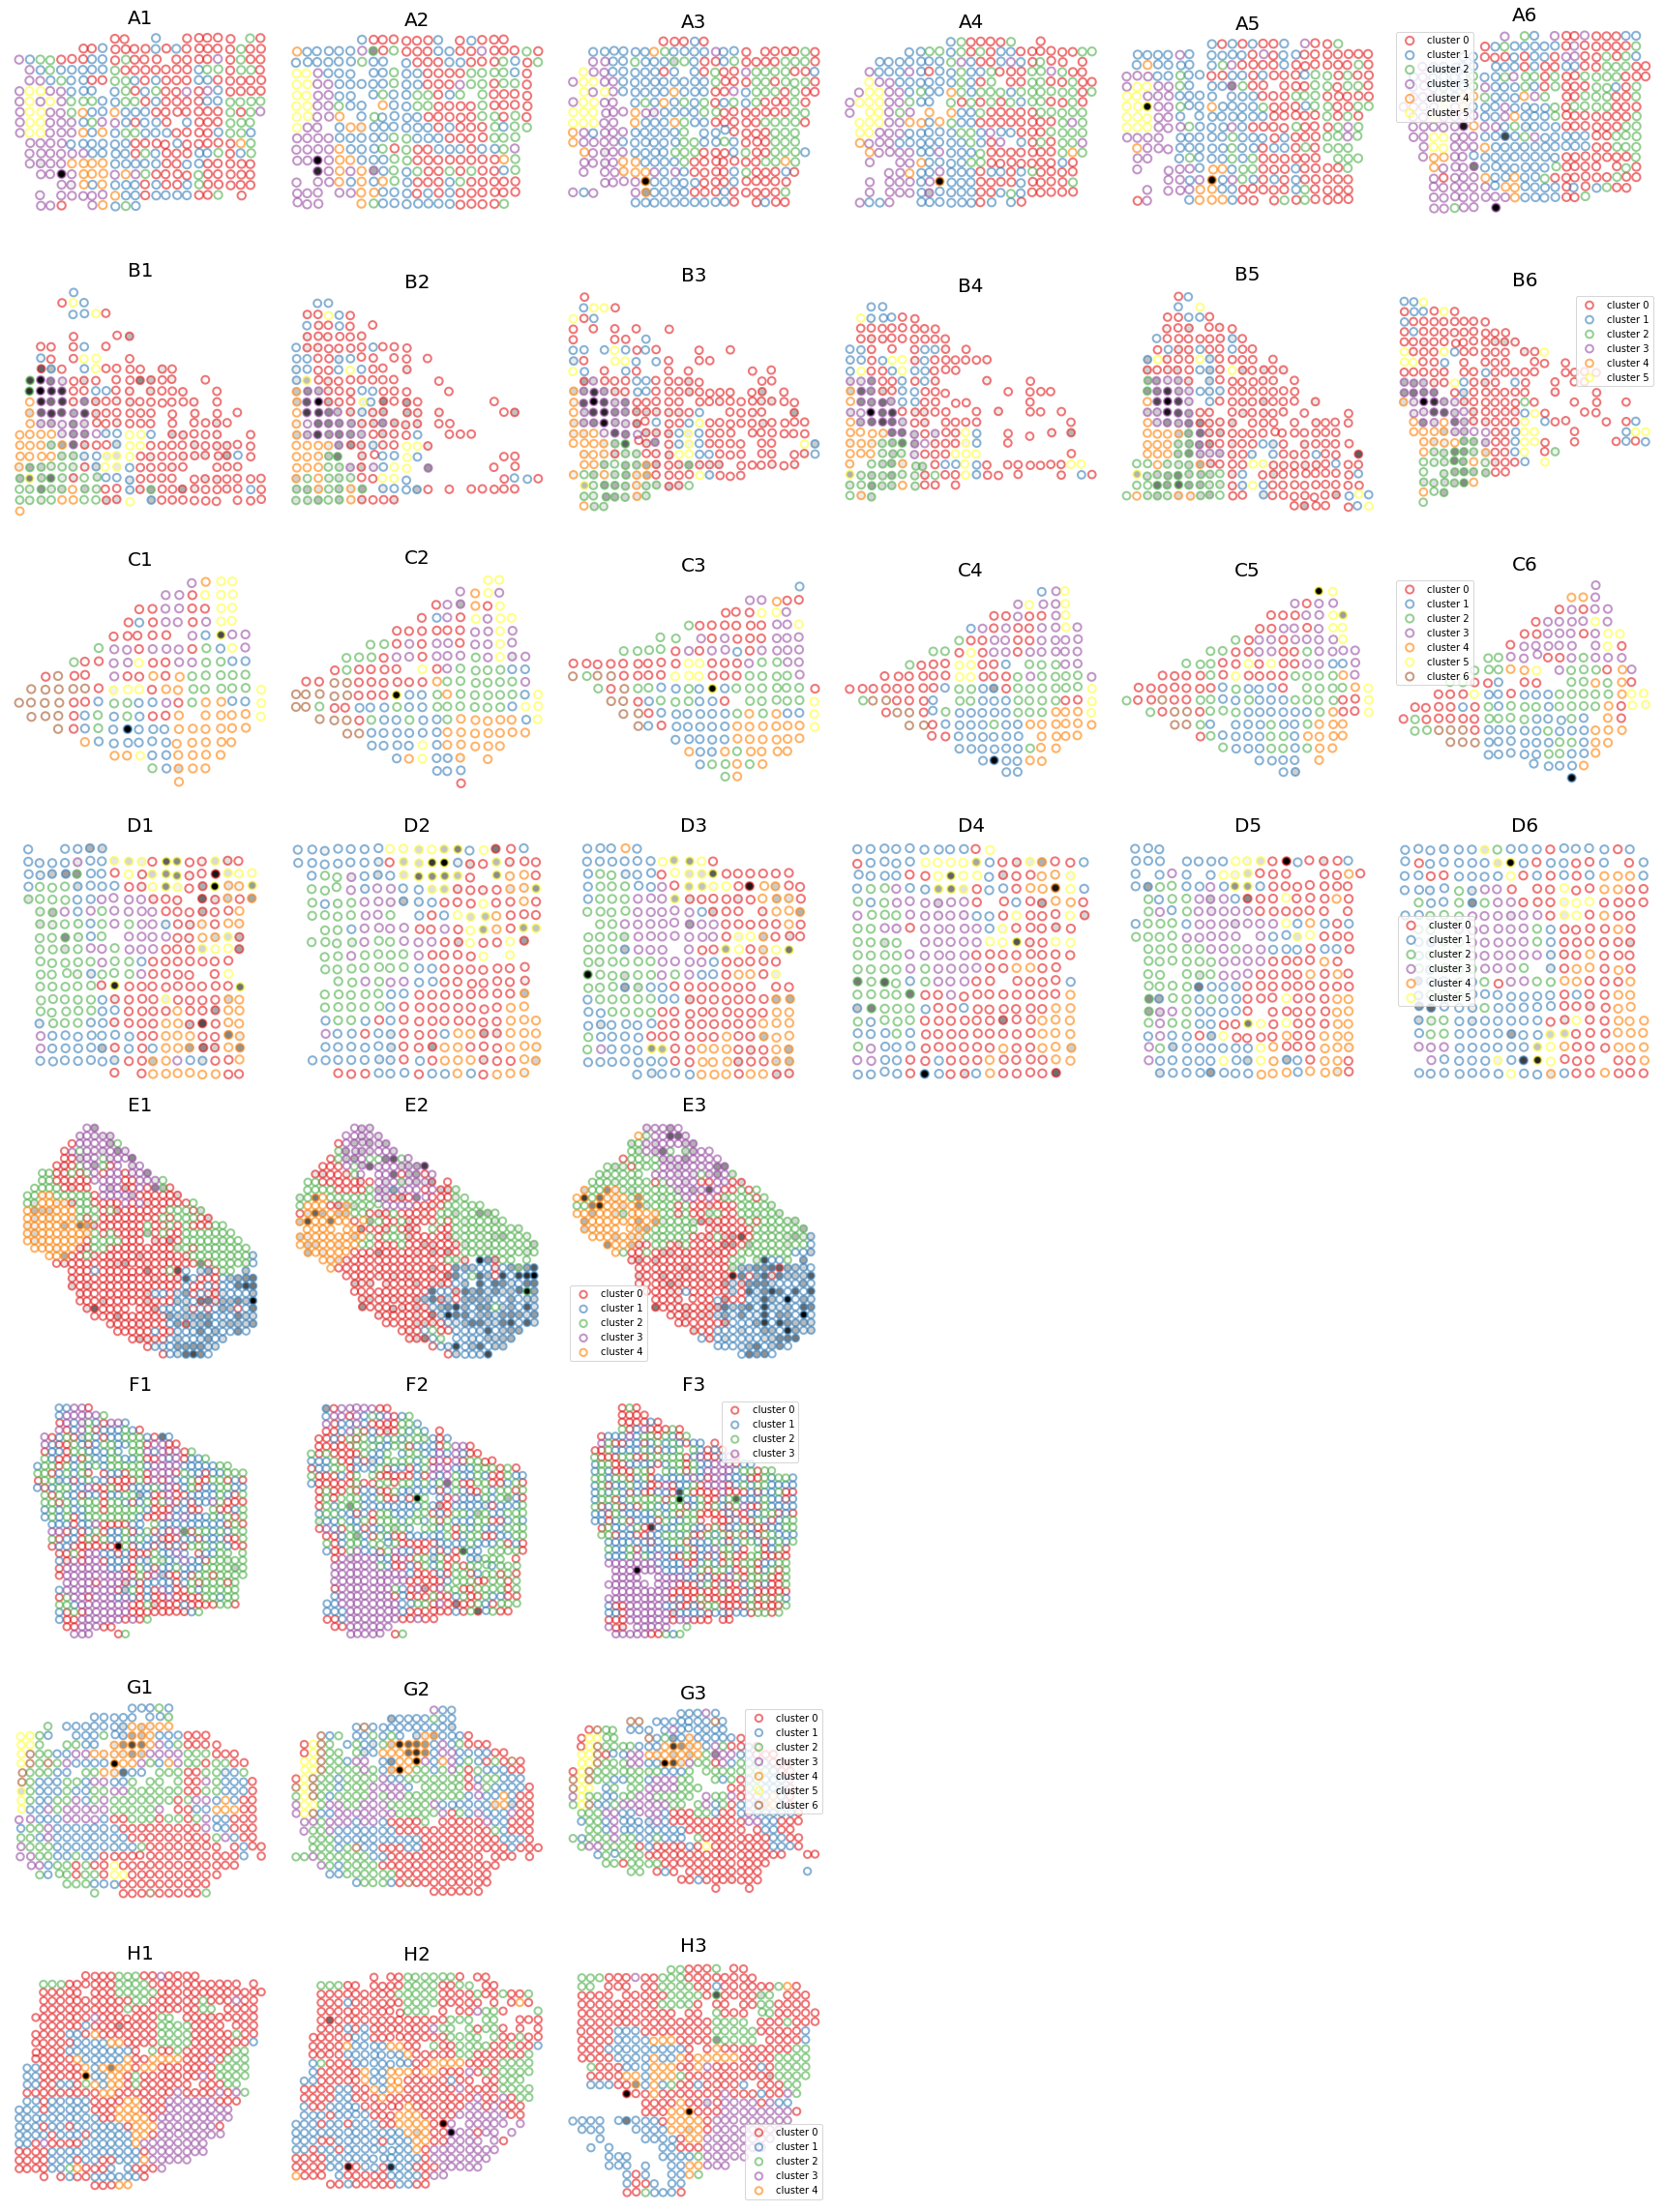

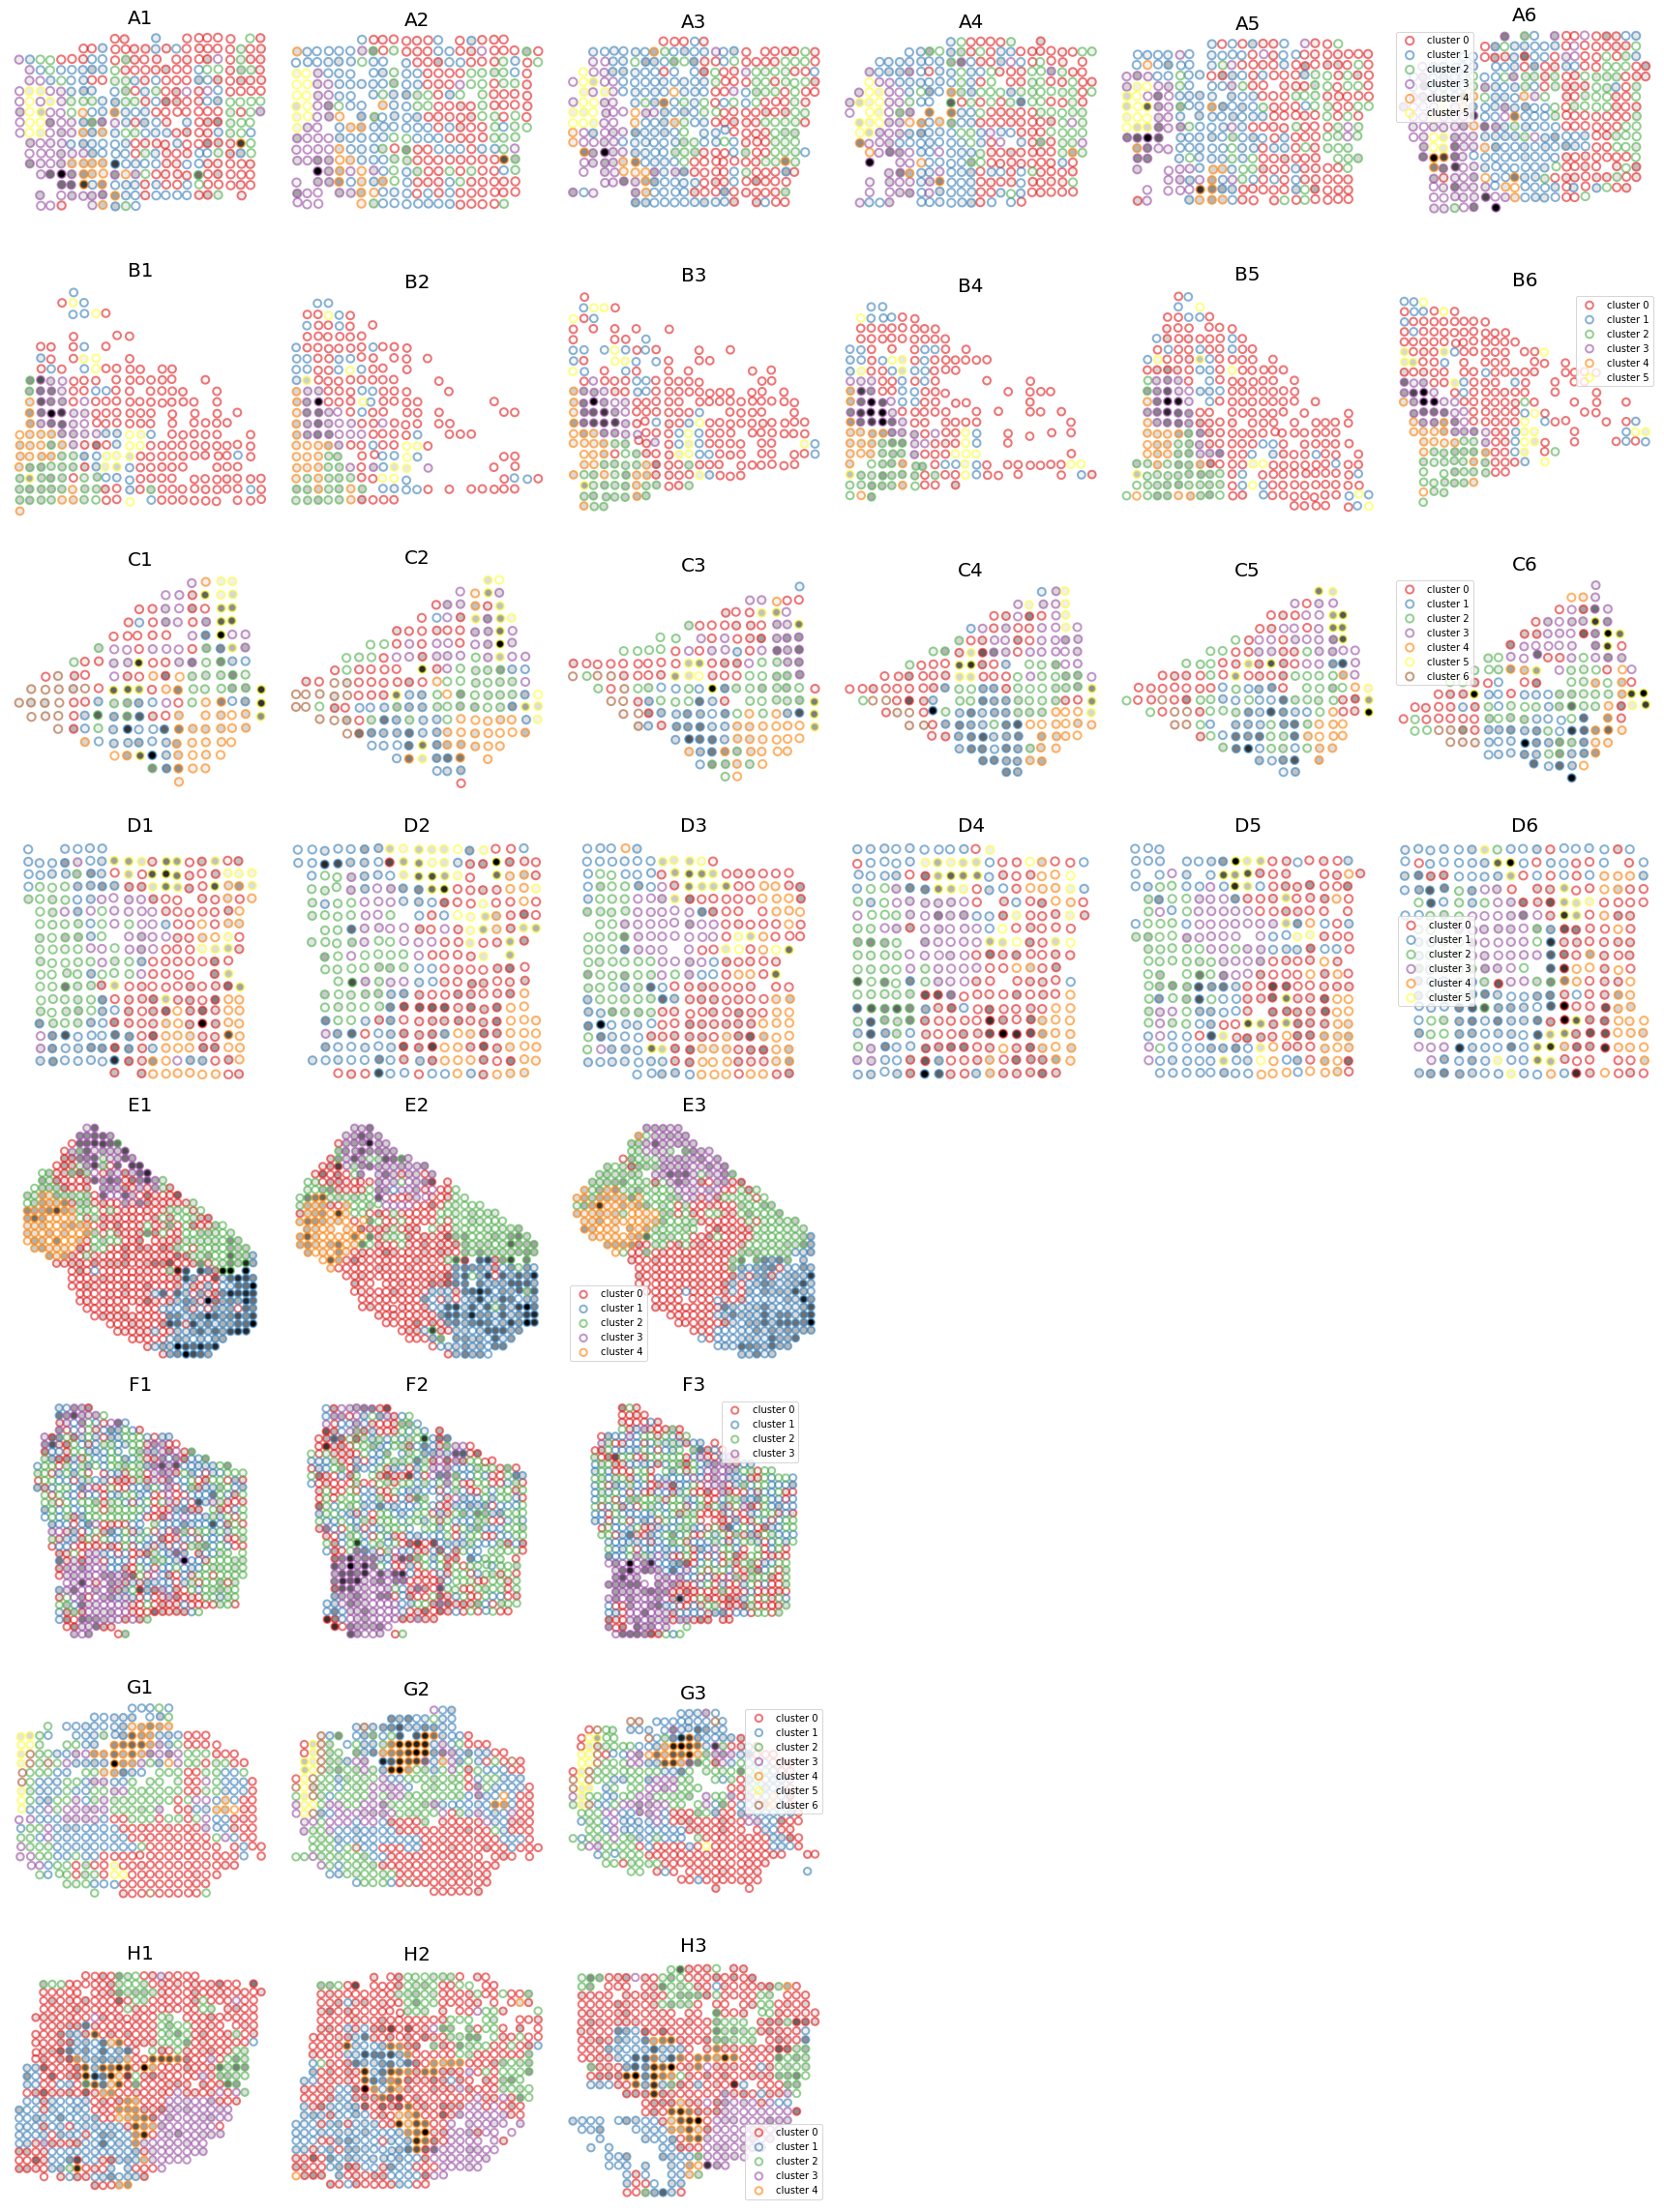

In [94]:

# get number of samples
n_samples = len(res)

# get number of replicates for each sample
rep_counts = Counter([x[0] for x in res.keys()])

# set number of rows to number of patients
n_rows = len(rep_counts)
# set number of columns to maximum number of replicates
# for a patient
n_cols = max(rep_counts.values())
# side size for subplots
side_size = 4

# function to map patient to row
rowmap = {pat:k for k,pat in enumerate(sorted(list(set([x[0] for x in res.keys()]))))}

# figure for beanplots
fig,ax = plt.subplots(n_rows,
                      n_cols,
                      figsize = (side_size * n_cols,
                                 side_size * n_rows),
                      sharey = True,
                      facecolor = "white",
                      )

# figure for spatial plots
fig2,ax2 = plt.subplots(n_rows,
                      n_cols,
                      figsize = (side_size * n_cols,
                                 side_size * n_rows),
                      facecolor ="white",
                      )

fig3,ax3 = plt.subplots(n_rows,
                      n_cols,
                      figsize = (side_size * n_cols,
                                 side_size * n_rows),
                      facecolor ="white",
                      )

# set colormap for clusters
clu_cmap = plt.cm.Set1
# set edgecolor for clusters
ec_alpha = 0.6

# set initial values  
rep_id = 0
row = ""

for idx in res.keys():
    
    # store old row id
    old_row = row
    # new row id is set to row associated with patient
    row = rowmap[idx[0]]
    # reset column position if new patient
    if old_row != row and old_row is not "":
        rep_id = 0
    
    # get number of cluster
    n_clust = len(res[idx])
    
    #set dist_ax
    
    dist_ax = ax[row,rep_id]
    
    # generate bean plot
    vps = bean_plot(dist_ax,
                    list(res[idx].values()),
                    cmap = clu_cmap,
                    edgecolor = "black",
                    )
    
    # customize plot
    dist_ax.set_xticklabels(list(res[idx].keys()),
                                   rotation = 90)
    dist_ax.set_title(idx,
                     fontsize = 20,
                     )
    
    dist_ax.set_xlabel("Cluster",
                       fontsize = 17, 
                      )
    dist_ax.tick_params(axis='x',
                        which='major',
                        labelsize=15)
    
    # dynamic marker size
    x_crd = crds[idx][:,0]
    y_crd = crds[idx][:,1]
    
    delta_x = x_crd.max() - x_crd.min()
    delta_y = y_crd.max()  - y_crd.min()
    
    delta =  max(delta_x,delta_y)
    
    marker_size = 5e3 / np.sqrt(delta) 
    
    
    # generate spatial plots
    for axx,vals in zip([ax2,ax3],[prods,enr_scores]):
        spat_ax = axx[row,rep_id]
        spat_ax.scatter(x_crd,
                        y_crd,
                        s = marker_size ,
                        c = vals[idx],
                        cmap = plt.cm.binary,
                        edgecolor = "none",
                        )

        # color spatial plot edges according to cluster
        for k,(clu,pos) in enumerate(clu_pos[idx].items()):
            ec = list(clu_cmap(k))
            ec[-1] = ec_alpha
            spat_ax.scatter(x_crd[pos],
                            y_crd[pos],
                            s = marker_size,
                            c = "none",
                            edgecolor = ec,
                            label = "cluster {}".format(clu),
                            linewidth = 2,
                            )

        # customize spatial plot
        spat_ax.invert_yaxis()
        spat_ax.axis("off")
        spat_ax.set_title(idx,
                         fontsize = 20,
                         )
        spat_ax.set_aspect("equal")

    
    # increase column position by 1
    rep_id += 1

# remove spines
for idx,row in rowmap.items():
    for axx in [ax,ax2,ax3]:
        for aa in axx[row,rep_counts[idx]::]: aa.axis("off")

# add legend to last subplot among spatial plots
for idx,col in rep_counts.items():
    row = rowmap[idx]
    ax2[row,col-1].legend()
    ax3[row,col-1].legend()
    
for idx in rep_counts.keys():
    row = rowmap[idx]
    ax[row,0].set_ylabel("Normalized Joint Score",
                        fontsize = 17,
                        )

# set tight layout
fig.tight_layout()
fig2.tight_layout()
fig3.tight_layout()


# save if specified
if save:
    fig.savefig(osp.join(RES_DIR,"beanplot-mac-t_cell-joint.png"))
    fig2.savefig(osp.join(RES_DIR,"crd-mac-t_cell-joint.png"))
    fig3.savefig(osp.join(RES_DIR,"crd-go-enr.png"))